## Dataset Loading

In [37]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

Path to dataset files: /Users/abhin-zstch1563/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4


In [38]:
import pandas as pd

df = pd.read_csv("fashion-mnist_train.csv")
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
import numpy as np
import seaborn as sns
import torch as t
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

## Data Preprocessing

In [40]:
X = np.array(df.drop(columns="label"))
X
y = np.array(df["label"])
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(60000, 784))

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [42]:
scaler = StandardScaler()
# X = scaler.fit_transform(X)
X = X / 255

In [43]:
X, y = t.from_numpy(X), t.from_numpy(y)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [45]:
X_train.shape #(48000, 784)
X_test.shape #(12000, 784)
y_train.shape #(48000)
y_test.shape #(12000)

torch.Size([12000])

In [46]:
df["label"].unique()


array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

## Model Architecture

In [47]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dims, 128),
            nn.BatchNorm1d(128), 
            nn.ReLU(),
            nn.Dropout(0.2), 
            nn.Linear(128, 64), 
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2), 
            # nn.Linear(64, 32),
            # nn.ReLU(),
            # nn.Dropout(0.1),
            nn.Linear(64, output_dims)
        )
    
    def forward(self, x):
        return self.layers(x)

In [48]:
model = NeuralNetwork(X_train.shape[1], 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

In [ ]:
train_data = t.utils.data.TensorDataset(X_train.float(), y_train.squeeze().long())
test_data = t.utils.data.TensorDataset(X_test.float(), y_test.squeeze().long())

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(train_data)


## Training Loop

In [50]:
epochs = 150
cost_hist = []

for i in range(epochs):
    model.train()
    total_loss = 0
    correct_train, total_train = 0, 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = t.max(output, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()

    train_acc = 100 * correct_train / total_train
    cost_hist.append(total_loss / len(train_loader))

    model.eval()
    correct_test, total_test = 0, 0
    with t.no_grad():
        outputs = model(X_batch)

        _, predicted = t.max(outputs, 1)
        total_test += y_batch.size(0)
        correct_test += (predicted == y_batch).sum().item()

        test_acc = 100 * correct_test / total_test


    print(f"Epoch: {i+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}, Training Acc: {train_acc:.2f}%, Testing Acc: {test_acc:.2f}%")



Epoch: 1/150, Loss: 0.5802, Training Acc: 80.77%, Testing Acc: 92.19%
Epoch: 2/150, Loss: 0.4228, Training Acc: 84.94%, Testing Acc: 89.06%
Epoch: 3/150, Loss: 0.3860, Training Acc: 86.23%, Testing Acc: 92.19%
Epoch: 4/150, Loss: 0.3589, Training Acc: 87.02%, Testing Acc: 87.50%
Epoch: 5/150, Loss: 0.3455, Training Acc: 87.21%, Testing Acc: 82.81%
Epoch: 6/150, Loss: 0.3256, Training Acc: 88.21%, Testing Acc: 89.06%
Epoch: 7/150, Loss: 0.3198, Training Acc: 88.12%, Testing Acc: 90.62%
Epoch: 8/150, Loss: 0.3091, Training Acc: 88.77%, Testing Acc: 90.62%
Epoch: 9/150, Loss: 0.2976, Training Acc: 89.19%, Testing Acc: 89.06%
Epoch: 10/150, Loss: 0.2924, Training Acc: 89.20%, Testing Acc: 85.94%
Epoch: 11/150, Loss: 0.2837, Training Acc: 89.63%, Testing Acc: 93.75%
Epoch: 12/150, Loss: 0.2774, Training Acc: 89.78%, Testing Acc: 93.75%
Epoch: 13/150, Loss: 0.2719, Training Acc: 90.05%, Testing Acc: 90.62%
Epoch: 14/150, Loss: 0.2602, Training Acc: 90.36%, Testing Acc: 96.88%
Epoch: 15/150, 

<Axes: >

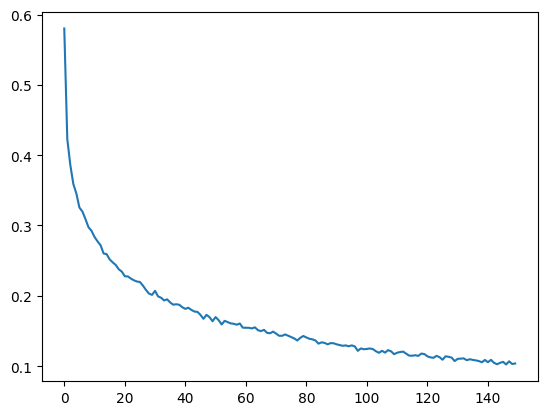

In [51]:
sns.lineplot(x= range(len(cost_hist)), y= cost_hist)

In [52]:
df_test = pd.read_csv("fashion-mnist_test.csv")
df_test

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,32,23,14,20,0,0,1,0,0,0
9996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
9998,8,0,1,3,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [53]:
X_test = np.array(df_test.drop(columns=["label"]))
# X_test = scaler.fit_transform(X_test)
X_test = X_test / 255
X_test = t.from_numpy(X_test)
X_test
y_test = np.array(df_test["label"])
y_test = t.from_numpy(y_test)
y_test

tensor([0, 1, 2,  ..., 8, 8, 1])

## Test Set Evaluation

In [54]:
model.eval()
correct_off, total_off = 0, 0
with t.no_grad():
    X_test = X_test.float()
    output_off = model(X_test)
    # y_test = y_test.long()

    _, predicted = t.max(output_off, 1)
    total_off = y_test.size(0)
    correct_off = (predicted == y_test).sum().item()

    accuracy = 100 * correct_off / total_off

print(f"Official test accuracy: {accuracy:.2f}%")

Official test accuracy: 89.72%


In [56]:
image = "data copy/val/9878.png"
new = ""
for n in image:
    if n.isnumeric():
        new += n
new = int(new)
print(new)

9878


## Inference on Images

(28, 28)


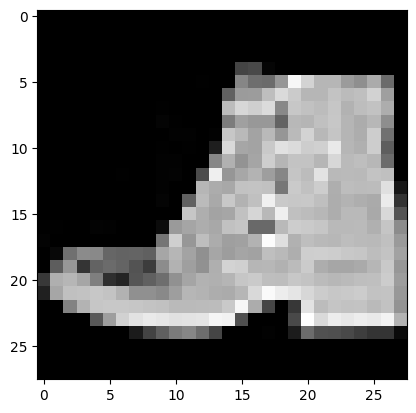

In [57]:
from PIL import Image

# 1️⃣ Open the image
img = Image.open(image)

# 2️⃣ Convert to grayscale (Fashion MNIST images are black and white)
img_gray = img.convert("L")

# 3️⃣ Resize to 28x28 pixels
img_resized = img_gray.resize((28, 28))

# 4️⃣ (Optional) Invert colors if needed (MNIST uses white digits on black background)
# from PIL import ImageOps
# img_resized = ImageOps.invert(img_resized)

# 5️⃣ Convert to numpy array for model input
import numpy as np
img_array = np.array(img_resized)

# 6️⃣ Normalize (same as MNIST preprocessing)
img_array = img_array / 255.0

# Now you have a 28x28 normalized image
print(img_array.shape)  # (28, 28)

# 7️⃣ Visualize
import matplotlib.pyplot as plt
plt.imshow(img_array, cmap='gray')
plt.show()


In [58]:
import torch
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),  # Converts to [0,1] and shape (1,28,28)
])

img_torch = transform(Image.open(image))
print(img_torch.shape)  # torch.Size([1, 28, 28])


torch.Size([1, 28, 28])


In [59]:
from PIL import Image
import numpy as np

def preprocess_image(image_path):
    # 1. Load image
    img = Image.open(image_path).convert("L")  # convert to grayscale
    
    # 2. Resize to 28x28 pixels (same as Fashion-MNIST)
    img = img.resize((28, 28))
    
    # 3. Convert to numpy array
    img_array = np.array(img)
    
    # 4. Normalize (same as during training)
    img_array = img_array / 255.0  # values between 0 and 1
    
    # 5. Flatten to 784 columns
    img_flattened = img_array.flatten().reshape(1, -1)  # shape (1, 784)
    
    return img_flattened


In [60]:
import torch

img_data = preprocess_image(image)
img_tensor = torch.tensor(img_data, dtype=torch.float32)

with torch.no_grad():
    outputs = model(img_tensor)
    predicted_class = torch.argmax(outputs, dim=1).item()

clothes = {0 : "T-shirt/top", 1 : "Trouser", 2 : "Pullover", 3 : "Dress", 4 : "Coat", 5 : "Sandal", 6 : "Shirt", 7 : "Sneaker", 8 : "Bag", 9 : "Ankle boot"}

print("Predicted class:", predicted_class, clothes[predicted_class])


Predicted class: 9 Ankle boot


In [61]:
check_df = pd.read_csv("data copy/val.csv")
check_df.loc[new]

Unnamed: 0        9878
Image_File    7707.png
Class                9
Name: 9878, dtype: object

In [62]:
# | Label | Class       |
# | ----: | ----------- |
# |     0 | T-shirt/top |
# |     1 | Trouser     |
# |     2 | Pullover    |
# |     3 | Dress       |
# |     4 | Coat        |
# |     5 | Sandal      |
# |     6 | Shirt       |
# |     7 | Sneaker     |
# |     8 | Bag         |
# |     9 | Ankle boot  |
